In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
%matplotlib inline

from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_percentage_error
from scipy.stats import mode, norm, skew
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error 
from prophet import Prophet
from prophet.plot import plot_plotly
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller


import warnings
import time
import datetime
import pickle

import warnings
warnings.filterwarnings("ignore")

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
hotel_booking_data = pd.read_csv('D:\Hotel_Forecast\Data\hotel_bookings.csv')

In [4]:
hotel_booking_data['children'] = hotel_booking_data['children'].fillna(0)
hotel_booking_data['children'] = hotel_booking_data['children'].apply(np.int64)

In [5]:
# Chuyển tháng thành số để dễ trực quan
datetime_object = hotel_booking_data['arrival_date_month'].str[0:3]
month_number = np.zeros(len(datetime_object))

# Tạo một cột mới dựa trên biểu diễn số của các tháng
for i in range(0, len(datetime_object)):
    datetime_object[i] = datetime.datetime.strptime(datetime_object[i], "%b")
    month_number[i] = datetime_object[i].month


month_number = pd.DataFrame(month_number).astype(int)

#Ghép 3 cột ngày tháng thành 1
hotel_booking_data['arrival_date'] = hotel_booking_data['arrival_date_year'].map(str) + '-' + month_number[0].map(str) + '-' \
                       + hotel_booking_data['arrival_date_day_of_month'].map(str)

 #Loại bỏ các cột không cần thiết
hotel_booking_data = hotel_booking_data.drop(['arrival_date_year', 'arrival_date_month', 'arrival_date_day_of_month',
                  'arrival_date_week_number'], axis=1)

In [ ]:
hotel_booking_data['arrival_date'] = pd.to_datetime(hotel_booking_data['arrival_date'])
hotel_booking_data['reservation_status_date'] = pd.to_datetime(hotel_booking_data['reservation_status_date'])

print('Datatype of the arrival_date:', hotel_booking_data['arrival_date'].dtype)
print('Datatype of the reservation_status_date:', hotel_booking_data['reservation_status_date'].dtype)

Datatype of the arrival_date: datetime64[ns]
Datatype of the reservation_status_date: datetime64[ns]


In [ ]:
hotel_booking_data['Total Guests'] = hotel_booking_data['adults'] + hotel_booking_data['children']

hotel_booking_data = hotel_booking_data[hotel_booking_data['Total Guests'] != 0]

hotel_booking_data['Total Stays'] = hotel_booking_data['stays_in_weekend_nights'] + hotel_booking_data['stays_in_week_nights']

dataNoCancel = hotel_booking_data[hotel_booking_data['is_canceled'] == 0]
dataNoCancel = dataNoCancel.reset_index(drop=True)

#Tinh so khach thuc te 
NumberOfGuests = dataNoCancel[['arrival_date', 'Total Guests']].copy()

NumberOfGuests

,arrival_date,Total Guests
0,2015-07-01,2
1,2015-07-01,2
2,2015-07-01,1
3,2015-07-01,1
4,2015-07-01,2
...,...,...
75006,2017-08-30,2
75007,2017-08-31,3
75008,2017-08-31,2
75009,2017-08-31,2


In [8]:
# Tính số lượng khách hàng ngày - Khách sạn
NumberOfGuests = dataNoCancel[['arrival_date', 'Total Guests']]
NumberOfGuests_Daily = dataNoCancel['Total Guests'].groupby(dataNoCancel['arrival_date']).sum()
NumberOfGuests_Daily = NumberOfGuests_Daily.resample('d').sum().to_frame()
NumberOfGuests_Daily

,Total Guests
arrival_date,
2015-07-01,188
2015-07-02,73
2015-07-03,77
2015-07-04,94
2015-07-05,80
...,...
2017-08-27,265
2017-08-28,247
2017-08-29,150


In [10]:
# Thêm các cột ngày, tháng, quý, năm vào DataFrame
NumberOfGuests_Daily['Year'] = NumberOfGuests_Daily.index.year
NumberOfGuests_Daily['Month'] = NumberOfGuests_Daily.index.month
NumberOfGuests_Daily['Day'] = NumberOfGuests_Daily.index.day
NumberOfGuests_Daily['Quarter'] = NumberOfGuests_Daily.index.quarter

# Tổng số khách theo năm
guests_by_year = NumberOfGuests_Daily.groupby('Year')['Total Guests'].sum().reset_index()

# Tổng số khách theo tháng
guests_by_month = NumberOfGuests_Daily.groupby('Month')['Total Guests'].sum().reset_index()

# Tổng số khách theo ngày
guests_by_day = NumberOfGuests_Daily.groupby('Day')['Total Guests'].sum().reset_index()

# Tổng số khách theo quý
guests_by_quarter = NumberOfGuests_Daily.groupby('Quarter')['Total Guests'].sum().reset_index()


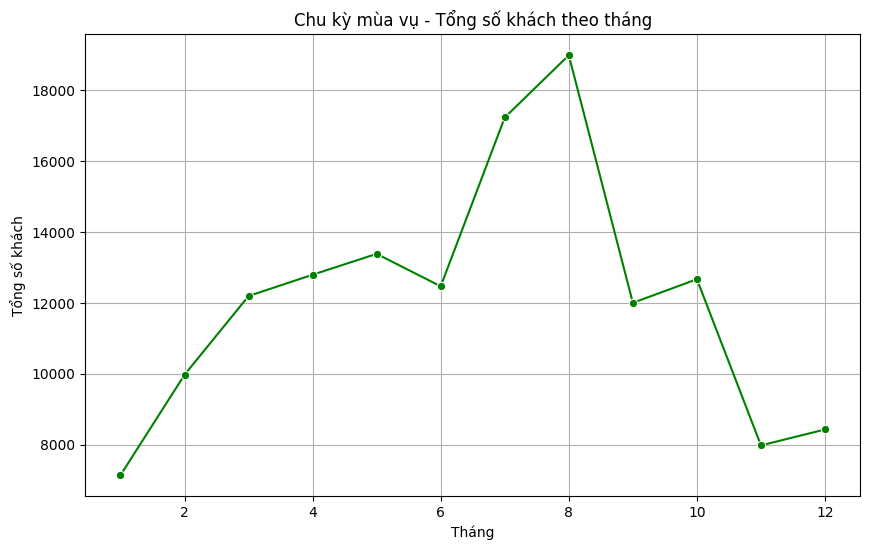

In [11]:
# Tính tổng số khách theo từng tháng trong năm (không phân biệt năm)
seasonality_data = NumberOfGuests_Daily.groupby('Month')['Total Guests'].sum().reset_index()

# Vẽ biểu đồ phân tích mùa vụ
plt.figure(figsize=(10, 6))
sns.lineplot(data=seasonality_data, x='Month', y='Total Guests', marker='o', color='green')
plt.title('Chu kỳ mùa vụ - Tổng số khách theo tháng')
plt.xlabel('Tháng')
plt.ylabel('Tổng số khách')
plt.grid(True)
plt.show()

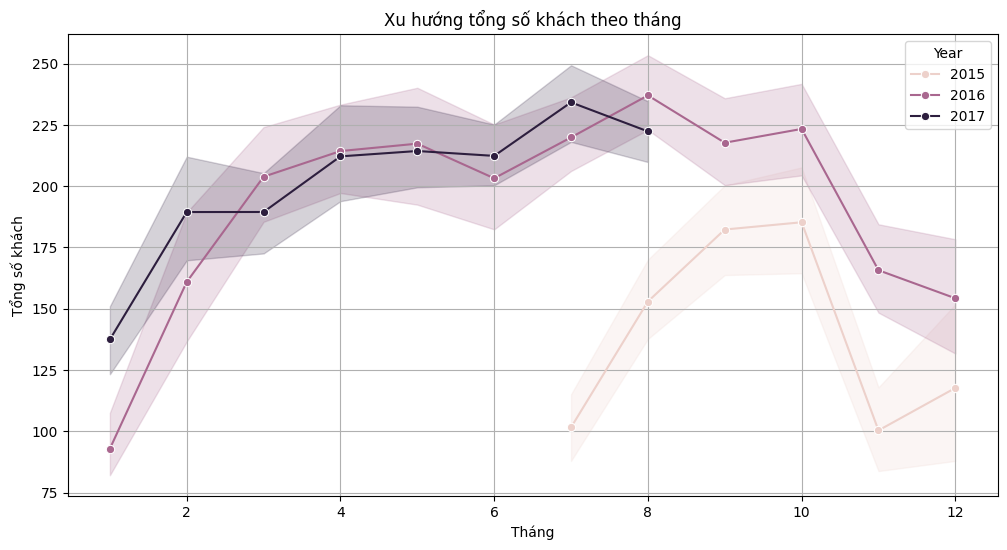

In [12]:
# Trực quan hóa xu hướng theo tháng
plt.figure(figsize=(12, 6))
sns.lineplot(data=NumberOfGuests_Daily, x='Month', y='Total Guests', hue='Year', marker='o')
plt.title('Xu hướng tổng số khách theo tháng')
plt.xlabel('Tháng')
plt.ylabel('Tổng số khách')
plt.grid(True)
plt.show()

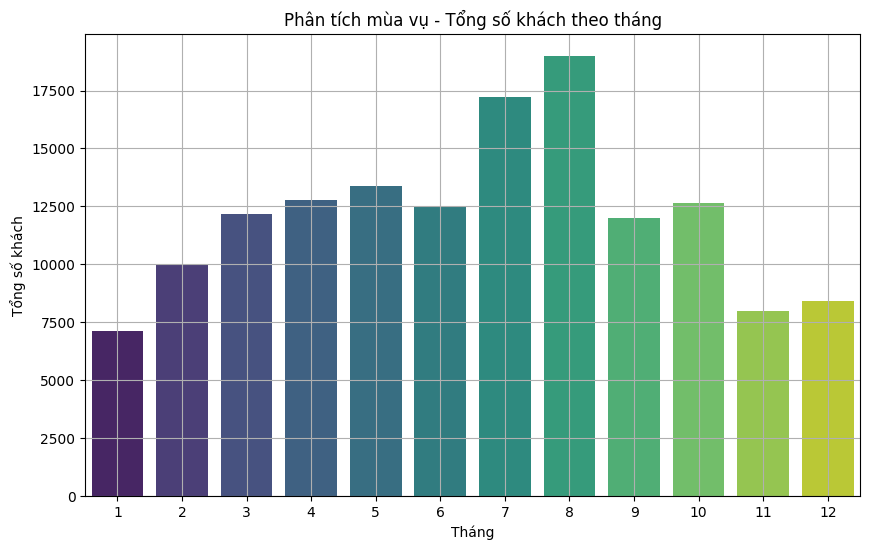

In [13]:
# Tính tổng số khách theo từng tháng trong năm (không phân biệt năm)
seasonality_data = NumberOfGuests_Daily.groupby('Month')['Total Guests'].sum().reset_index()

# Vẽ biểu đồ phân tích mùa vụ
plt.figure(figsize=(10, 6))
sns.barplot(data=seasonality_data, x='Month', y='Total Guests', palette='viridis')
plt.title('Phân tích mùa vụ - Tổng số khách theo tháng')
plt.xlabel('Tháng')
plt.ylabel('Tổng số khách')
plt.grid(True)
plt.show()

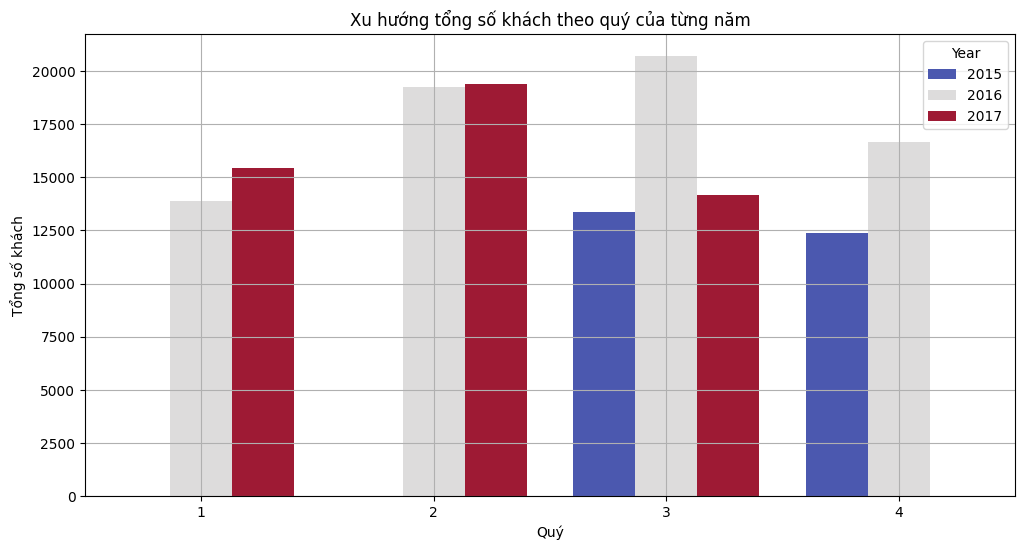

In [ ]:
# Group by quy va nam
NumberOfGuests_Daily['Quarter-Year'] = NumberOfGuests_Daily['Year'].astype(str) + '-Q' + NumberOfGuests_Daily['Quarter'].astype(str)
guests_by_quarter_year = NumberOfGuests_Daily.groupby(['Year', 'Quarter'])['Total Guests'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=guests_by_quarter_year, x='Quarter', y='Total Guests', hue='Year', palette='coolwarm')
plt.title('Xu hướng tổng số khách theo quý của từng năm')
plt.xlabel('Quý')
plt.ylabel('Tổng số khách')
plt.grid(True)
plt.show()

## ARIMA

### Kiểm tra xem chuỗi có dừng không

In [ ]:
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [16]:
adf_test(NumberOfGuests_Daily['Total Guests'])

Results of Dickey-Fuller Test:
Test Statistic                  -2.603322
p-value                          0.092313
#Lags Used                      20.000000
Number of Observations Used    772.000000
Critical Value (1%)             -3.438849
Critical Value (5%)             -2.865291
Critical Value (10%)            -2.568767
dtype: float64


### Làm dừng chuỗi

In [ ]:
def obtain_adf_results(timeseries, max_d):
    results = []

    for d in range(max_d + 1):
        adf_result = adfuller(timeseries, autolag='AIC')
        p_value = adf_result[1]
        is_stationary = p_value <= 0.05
        results.append((d, adf_result[0], p_value, is_stationary))

        timeseries = timeseries.diff().dropna()

    results_df = pd.DataFrame(results, columns=['d', 'ADF Statistic', 'p-value', 'Stationary'])
    return results_df


In [ ]:
obtain_adf_results(NumberOfGuests_Daily['Total Guests'], 3)

,d,ADF Statistic,p-value,Stationary
0,0,-2.603322,9.231258e-02,False
1,1,-10.274579,3.921010e-18,True
2,2,-13.093078,1.771988e-24,True
3,3,-14.450682,7.106964e-27,True


d = 1

### ACF và PACF

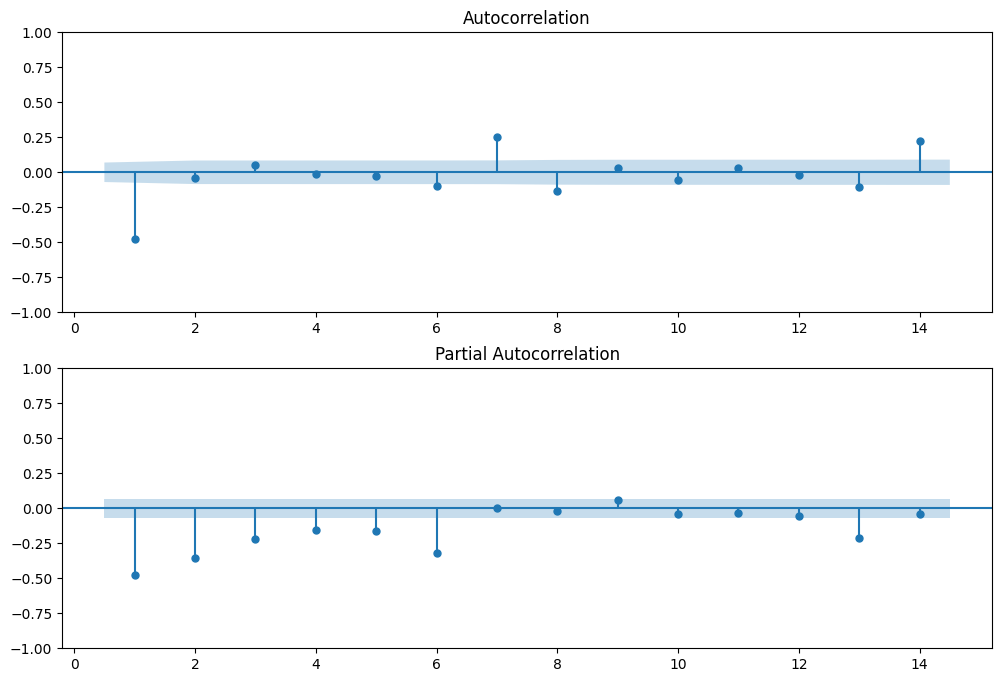

In [ ]:

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
 
# ACF NumberOfGuests_Daily
plot_acf(NumberOfGuests_Daily['Total Guests'].diff().dropna(),lags=14, zero=False, ax=ax1)

# PACF  NumberOfGuests_Daily
plot_pacf(NumberOfGuests_Daily['Total Guests'].diff().dropna(),lags=14, zero=False, ax=ax2)

plt.show()

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(NumberOfGuests_Daily['Total Guests'], order=(1,1,1), freq='D')
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Total Guests   No. Observations:                  793
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -4325.726
Date:                Thu, 19 Jun 2025   AIC                           8657.452
Time:                        21:03:37   BIC                           8671.475
Sample:                    07-01-2015   HQIC                          8662.841
                         - 08-31-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0206      0.036      0.575      0.565      -0.049       0.091
ma.L1         -0.8958      0.017    -52.281      0.000      -0.929      -0.862
sigma2      3241.2257     98.933     32.762      0.000    3047.320    3435.132
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               649.56
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.62   Skew:                             1.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
order_aic_bic=[]

for p in range(7):
    for q in range(7):
        # Fit model
        # model = SARIMAX(NumberOfGuests_Daily, order=(p,1,q), freq="D") #d =1
        model = ARIMA(NumberOfGuests_Daily[['Total Guests']], order=(p,1,q), freq="D") #d =1
        results = model.fit()
        order_aic_bic.append((p,q,results.aic, results.bic))

In [ ]:
# Tim p,q phu hop dua tren AIC va BIC
order_df = pd.DataFrame(order_aic_bic, 
                        columns=['p','q','AIC','BIC'])
order_df.sort_values('AIC')

,p,q,AIC,BIC
48,6,6,8609.655302,8670.424600
41,5,6,8611.270342,8667.365079
47,6,5,8618.624359,8674.719095
27,3,6,8628.085600,8674.831214
42,6,0,8633.308066,8666.029995
45,6,3,8634.994009,8681.739623
43,6,1,8635.225016,8672.621507
17,2,3,8635.617227,8663.664596
46,6,4,8636.099239,8687.519414
44,6,2,8636.492600,8678.563653


AIC agree the best model in this case should be ARIMA(6,1,6).
So I choice ARIMA(6,1,6)

In [23]:
df_train = NumberOfGuests_Daily['Total Guests'][:701]
df_test = NumberOfGuests_Daily['Total Guests'][701:]

In [ ]:
arima_model = ARIMA(df_train, order=(6,1,6))
# arima_model = SARIMAX(df_train, order=(6,1,6))
# fit model
arima_results = arima_model.fit()
yhat = arima_results.forecast(len(df_test))
#mae = np.mean(np.abs(arima_results.resid))
MAE_1 = mean_absolute_error(df_test, yhat)

print('MAE: %.3f' % MAE_1)

MAPE_1 = mean_absolute_percentage_error(df_test, yhat)
print('MAPE: %.3f' % MAPE_1)

MAE: 30.671
MAPE: 0.141


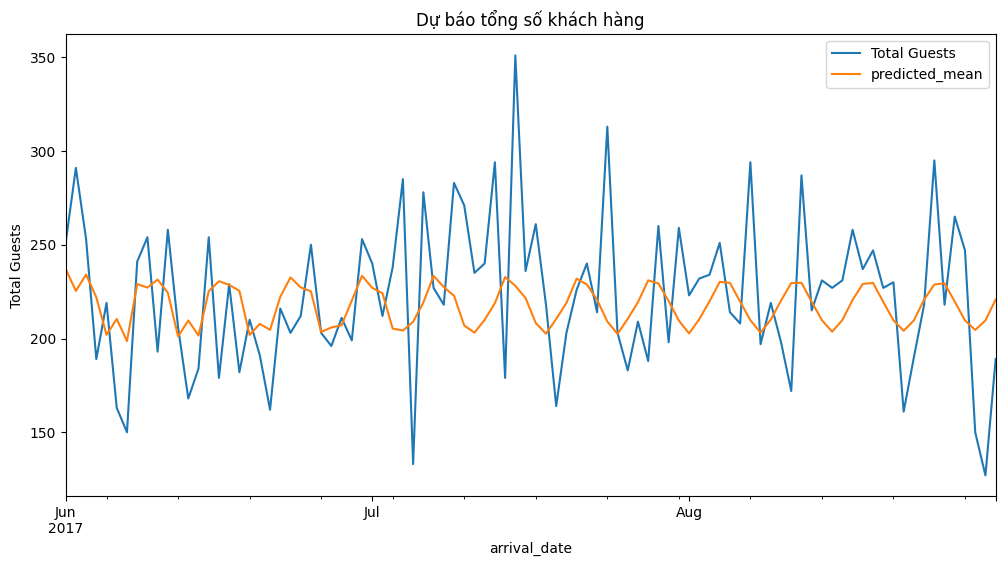

In [25]:
ax = df_test.plot(legend=True,figsize=(12,6),title='Dự báo tổng số khách hàng')
yhat.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(ylabel='Total Guests');

In [26]:
arima_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Total Guests   No. Observations:                  701
Model:                 ARIMA(6, 1, 6)   Log Likelihood               -3815.848
Date:                Thu, 19 Jun 2025   AIC                           7657.697
Time:                        21:03:59   BIC                           7716.861
Sample:                    07-01-2015   HQIC                          7680.567
                         - 05-31-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9125      0.226     -4.031      0.000      -1.356      -0.469
ar.L2         -0.1940      0.107     -1.806      0.071      -0.405       0.017
ar.L3         -0.5099      0.060     -8.448      0.000      -0.628      -0.392
ar.L4         -1.1429      0.120     -9.494      0.000      -1.379      -0.907
ar.L5         -0.5187      0.213     -2.436      0.015      -0.936      -0.101
ar.L6         -0.1460      0.054     -2.722      0.006      -0.251      -0.041
ma.L1          0.0403      0.232      0.174      0.862      -0.414       0.494
ma.L2         -0.6696      0.115     -5.843      0.000      -0.894      -0.445
ma.L3          0.3479      0.136      2.552      0.011       0.081       0.615
ma.L4          0.7612      0.149      5.097      0.000       0.469       1.054
ma.L5         -0.4937      0.124     -3.980      0.000      -0.737      -0.251
ma.L6         -0.3746      0.195     -1.925      0.054      -0.756       0.007
sigma2      3302.4517    113.341     29.137      0.000    3080.307    3524.596
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):               744.46
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               0.73   Skew:                             1.15
Prob(H) (two-sided):                  0.02   Kurtosis:                         7.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [27]:
df_arima_results = pd.DataFrame({'metrics':['MAE','MAPE'],
              'ARIMA(6,1,6)':[round(MAE_1,3), 
                 round(MAPE_1,4)]})

In [28]:
df_arima_results

,metrics,"ARIMA(6,1,6)"
0,MAE,30.6710
1,MAPE,0.1413


# Prophet

In [29]:
NumberOfGuests_Daily = NumberOfGuests_Daily['Total Guests'].reset_index()
NumberOfGuests_Daily.columns = ['ds','y']

In [30]:
NumberOfGuests_Daily

,ds,y
0,2015-07-01,188
1,2015-07-02,73
2,2015-07-03,77
3,2015-07-04,94
4,2015-07-05,80
...,...,...
788,2017-08-27,265
789,2017-08-28,247
790,2017-08-29,150
791,2017-08-30,127


In [31]:
from prophet.make_holidays import make_holidays_df
holidays = make_holidays_df(year_list=[2015, 2017], country='PT')
holidays['lower_window'] = -2
holidays['upper_window'] = 2

In [32]:
df_trainProphet = NumberOfGuests_Daily[:701]
df_testProphet = NumberOfGuests_Daily[701:]

Fit model

In [33]:
model = Prophet(
    holidays=holidays,
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode='multiplicative',
    interval_width=0.95
)
model.fit(df_trainProphet)

21:03:59 - cmdstanpy - INFO - Chain [1] start processing
21:04:00 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
#Tao futute dataframe
future = model.make_future_dataframe(periods=len(df_testProphet)) 
future

,ds
0,2015-07-01
1,2015-07-02
2,2015-07-03
3,2015-07-04
4,2015-07-05
...,...
788,2017-08-27
789,2017-08-28
790,2017-08-29
791,2017-08-30


In [35]:
forecast = model.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,All Saints' Day,All Saints' Day_lower,All Saints' Day_upper,Assumption Day,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2015-07-01,113.855040,4.056174,205.873408,113.855040,113.855040,0.0,0.0,0.0,0.0,...,-0.083848,-0.083848,-0.083848,0.042911,0.042911,0.042911,0.0,0.0,0.0,109.194182
1,2015-07-02,114.160050,27.781311,227.344734,114.160050,114.160050,0.0,0.0,0.0,0.0,...,0.063039,0.063039,0.063039,0.043111,0.043111,0.043111,0.0,0.0,0.0,126.278167
2,2015-07-03,114.465059,35.326614,232.339322,114.465059,114.465059,0.0,0.0,0.0,0.0,...,0.122204,0.122204,0.122204,0.042378,0.042378,0.042378,0.0,0.0,0.0,133.303972
3,2015-07-04,114.770069,28.282523,221.026208,114.770069,114.770069,0.0,0.0,0.0,0.0,...,0.072607,0.072607,0.072607,0.040760,0.040760,0.040760,0.0,0.0,0.0,127.781210
4,2015-07-05,115.075079,14.988060,208.047632,115.075079,115.075079,0.0,0.0,0.0,0.0,...,-0.083041,-0.083041,-0.083041,0.038340,0.038340,0.038340,0.0,0.0,0.0,109.931113


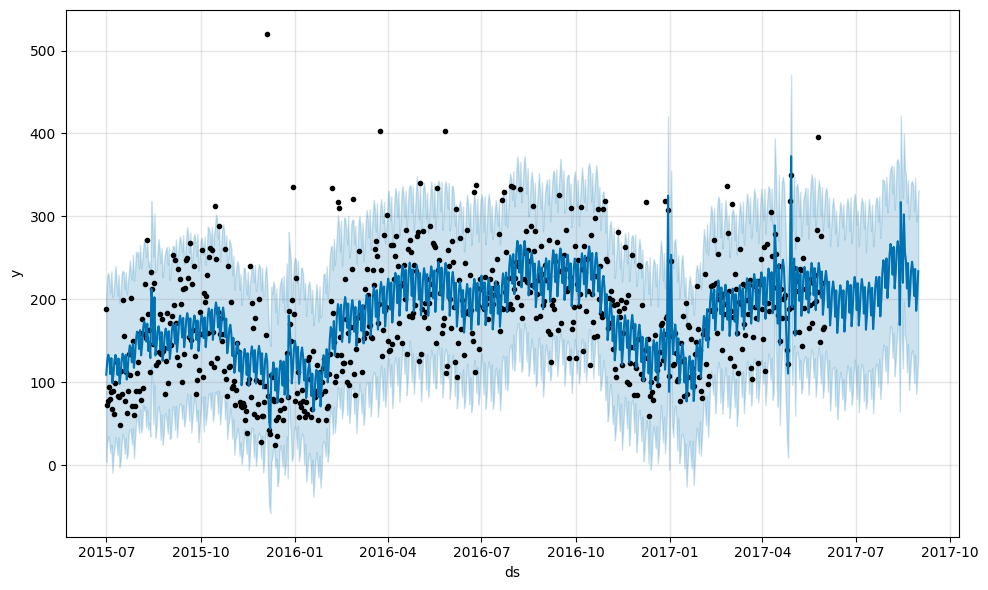

In [36]:
plot1 = model.plot(forecast)

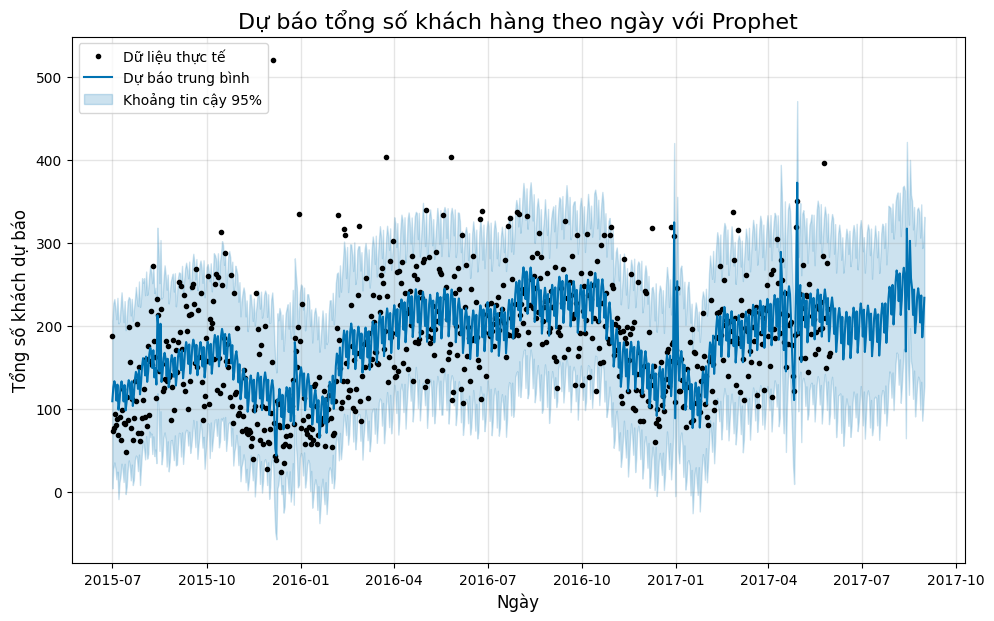

In [37]:
plot1 = model.plot(forecast)
plt.title('Dự báo tổng số khách hàng theo ngày với Prophet', fontsize=16)
plt.xlabel('Ngày', fontsize=12)
plt.ylabel('Tổng số khách dự báo', fontsize=12)
plt.legend(['Dữ liệu thực tế', 'Dự báo trung bình', 'Khoảng tin cậy 95%'], loc='upper left')
plt.grid(True)
plt.show()

# Đánh giá sai số của mô hình

In [38]:
# Chỉ lấy phần forecast tương ứng với tập test
forecast_test = forecast.iloc[701:].copy()

# Gộp dữ liệu test với dự báo tương ứng
df_test = df_testProphet.copy()
df_merge = df_test.merge(forecast_test[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds')


In [39]:
y_true = df_merge['y'].values
y_pred = df_merge['yhat'].values
mae_01 = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae_01)
mape_01 = mean_absolute_percentage_error(y_true, y_pred)
print('MAPE: %.3f' % mape_01)

MAE: 33.096
MAPE: 0.148


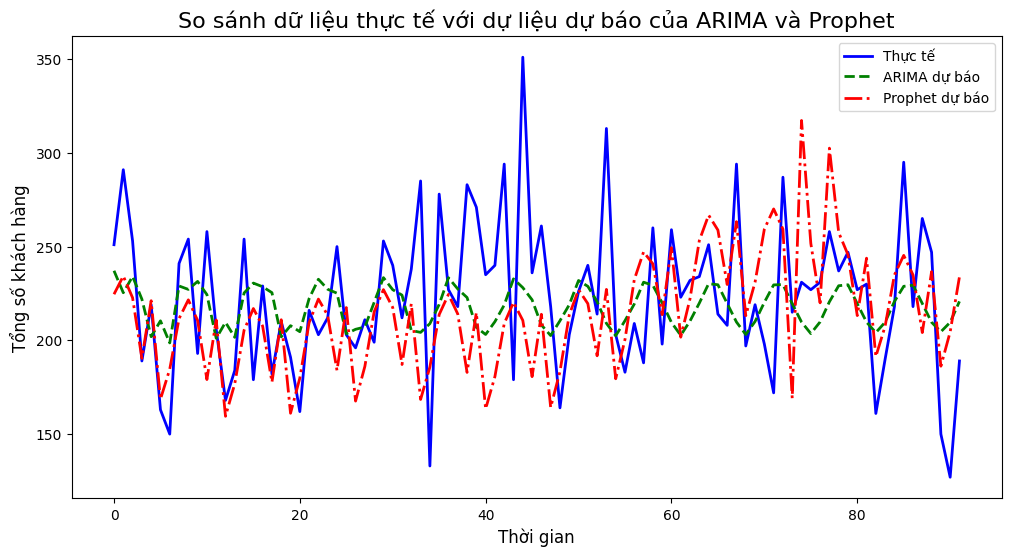

In [40]:
plt.figure(figsize=(12, 6))

# Vẽ giá trị thực tế
plt.plot(y_true, label='Thực tế', color='blue', linewidth=2)

# Vẽ giá trị dự báo của mô hình ARIMA
plt.plot(yhat.values, label='ARIMA dự báo', color='green', linestyle='--', linewidth=2)

# Vẽ giá trị dự báo của mô hình Prophet
plt.plot(y_pred, label='Prophet dự báo', color='red', linestyle='-.', linewidth=2)

# Thêm tiêu đề và nhãn
plt.title('So sánh dữ liệu thực tế với dự liệu dự báo của ARIMA và Prophet', fontsize=16)
plt.xlabel('Thời gian', fontsize=12)
plt.ylabel('Tổng số khách hàng', fontsize=12)

# Hiển thị chú thích
plt.legend()

# Hiển thị biểu đồ
plt.show()